### Q1
> 1. Correlation coefficients are bound between -1 and 1. This $\rho_{ij}$ is no exception. $$ -1 \leq \rho_{ij} \leq 1 $$  
> 2. $q_i(t)$ has range -1 to infinity. We may see that the positive and negative portions are not equally scaled. By using log-normalization, we may transform the skewed scale back to normal.

### Q2

In [6]:
library(igraph)
library(xts)

In [7]:
dir = "./finance_data/data/"
file_names = list.files(dir)

data = list()
for (name in file_names){
    tmp = read.csv(paste(dir, name, sep=''))
    if (grepl('.csv', name)){
        if (grepl('\\.B\\.csv', name)){
            data[[name]] = xts(tmp[,5], order.by=as.Date(tmp$Date, format="%m/%d/%y"))
        }else{
            data[[name]] = xts(tmp[,5], order.by=as.Date(tmp$Date))
        }
    }
}

In [8]:
df <- data.frame(matrix(ncol = 3, nrow = 0))
colnames(df) <- c("node1", "node2", "weights")

In [9]:
compute_cor = function(lst1, lst2){
    r1 = (diff(log(lst1), lag=1))[-1]
    r2 = (diff(log(lst2), lag=1))[-1]
    if (length(r1) == length(r2))
        return( cor(r1, r2) )
    else
        return (-2)
}

In [ ]:
num_nodes = length(data)

count = 0
flag = 0
for ( i in 1:num_nodes ){
    if (i%%10 == 1){
        print(i)
        flush.console()
    }
    for (j in 1:num_nodes){
        if (j > i){
            corr = compute_cor(data[[i]], data[[j]])
            if (corr != -2){
                count = count + 1
                weight = sqrt(2 * (1-corr))
                df[count, 1] = names(data[i])
                df[count, 2] = names(data[j])
                df[count, 3] = weight
            }
        }
    }
}

In [ ]:
saveRDS(df, "egdelist_df.RDS")

In [10]:
df = readRDS("egdelist_df.RDS")

In [11]:
g1 = graph.data.frame(df, directed = FALSE)

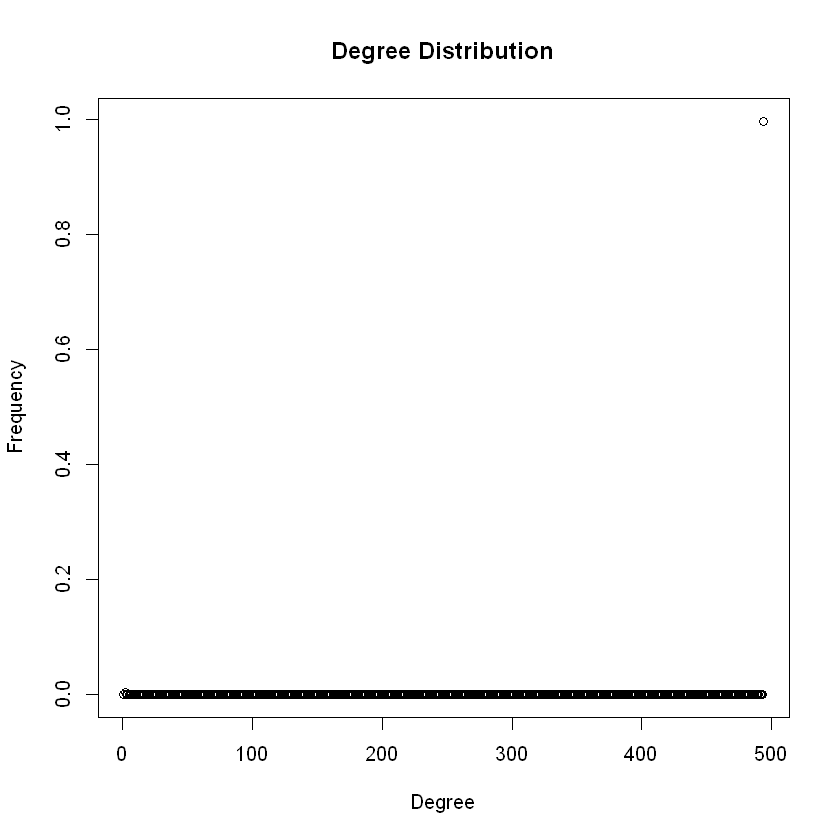

In [12]:
plot(degree.distribution(g1), main="Degree Distribution", xlab="Degree", ylab="Frequency")

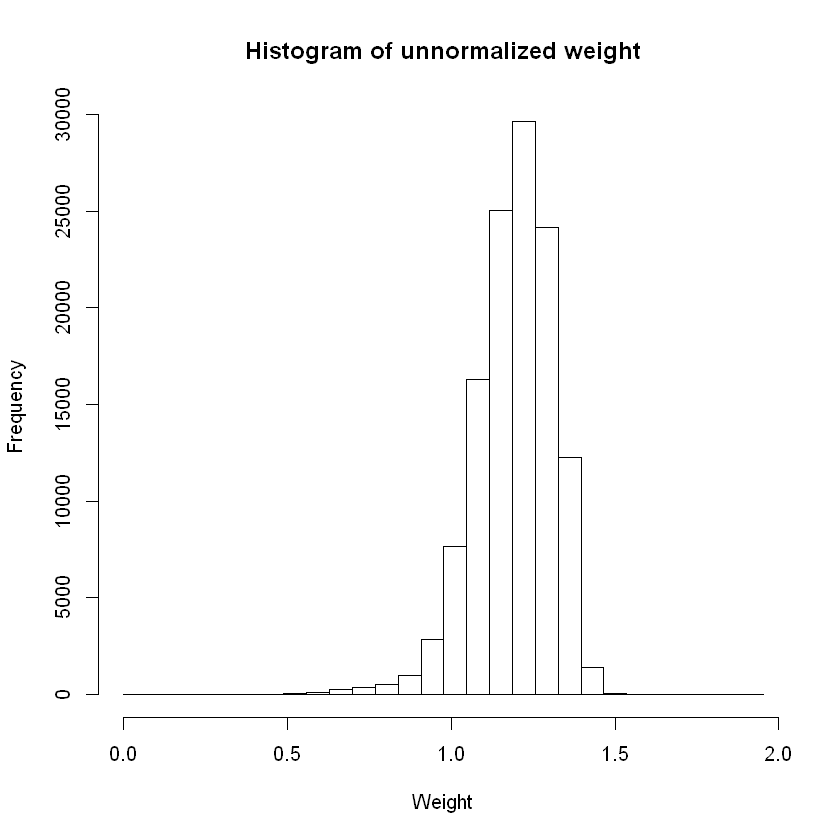

In [13]:
max_w = max(df[,3])
min_w = min(df[,3])
hist(df[,3], main="Histogram of unnormalized weight", xlab="Weight", breaks = seq(from = round(min_w), to = round(max_w), by = (max_w-min_w)/20))

In [14]:
sectors = read.csv("./finance_data/Name_sector.csv", stringsAsFactors=FALSE)

In [15]:
set = unique(sectors$Sector)
sector_set = list(name = set)

In [16]:
colors = c()
for (i in 1:length(sectors$Sector)){
    c = which(sector_set$name == sectors$Sector[i])
    colors = c(colors, c)
}

In [17]:
vcolor = c()
for (i in 1:length(V(g1))){
    node_name = substr(V(g1)$name[i],1,nchar(V(g1)$name[i])-4)
    set_id = which(sectors$Symbol == node_name)
    c = colors[set_id]
    vcolor = c(vcolor, c)
}

In [33]:
mst1 = mst(g1, weights = df$weights)

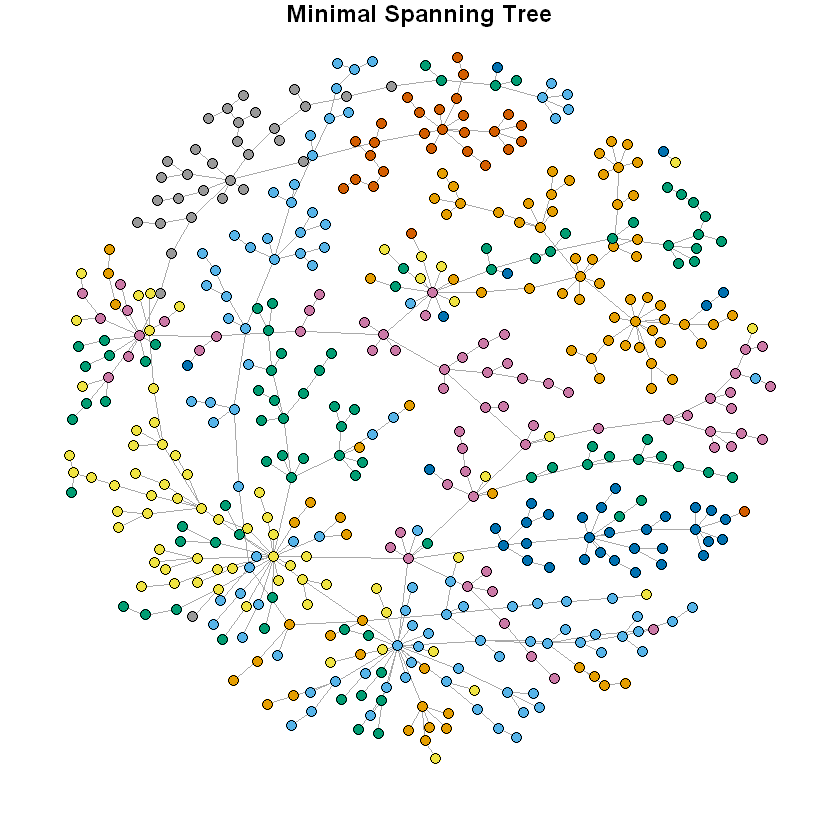

In [34]:
par(mfrow=c(1,1), mar=c(2,1,1,1)) 
plot(mst1, vertex.color = vcolor, vertex.label = NA, vertex.size = 3, main = "Minimal Spanning Tree")

### Q4

In [35]:
find_color = function(name){
    node_name = substr(name,1,nchar(name)-4)
    set_id = which(sectors$Symbol == node_name)
    c = colors[set_id]
    return (c)
}

In [36]:
V(mst1)$color = vcolor

In [45]:
# alpha 1
prob_sum = 0

for (v in V(mst1)){
    c_self = V(mst1)[v]$color
    neigh = neighbors(mst1, v)
    count = 0
    for (nei in neigh){
        if(V(mst1)[nei]$color == c_self){
            count = count + 1
        }
    }
    prob_sum = prob_sum + count/length(neigh)
}
alpha1 = prob_sum / length(V(mst1))
print(alpha1)

[1] 0.8255876


In [54]:
# alpha 2
prob_sum = 0

len = length(V(mst1))

sector_size = c()
for( i in 1:length(sector_set$name)){
    count = 0
    for (j in 1:length(vcolor)){
        if(vcolor[j] == i){
            count = count + 1
        }
    }
    sector_size = c(sector_size, count)
}

In [55]:
sector_size

[1] 60 64 84 67 37 28 63 31 24 34  4

In [56]:
for (v in V(mst1)){
    c_self = V(mst1)[v]$color
    prob_sum = prob_sum + sector_size[c_self]/len
}
alpha2 = prob_sum / len
print(alpha2)

[1] 0.1141064


### Q5